# Day2.2 BackPropagation & Learning Rate

### 실습 목표
- MNIST 데이터셋에서 0과 1 이미지를 예측하는 모델을 학습
- 모델의 학습 과정(Back Propagation)이 코드 상에서 어떻게 구현되는지 확인하고, Trainig Curve와 Learning Rate에 따른 성능 변화를 확인  
  <details>
  <summary> 데이터셋 상세 정보 </summary>

  MNIST : 0부터 9까지의 흑백 숫자 이미지들로 이루어진 데이터 셋, 28x28 크기, 7만장

  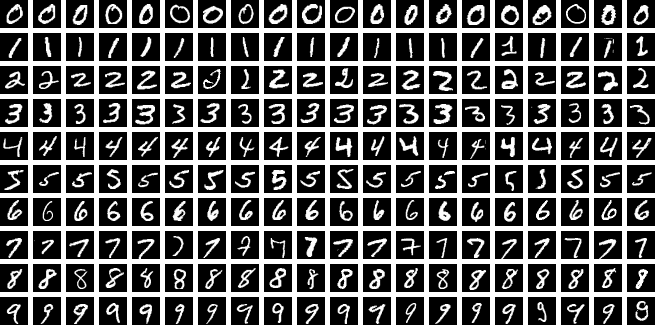

  </details>


## 0. Setting

- 런타임 > 런타임 유형 변경 > GPU



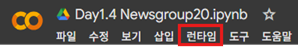

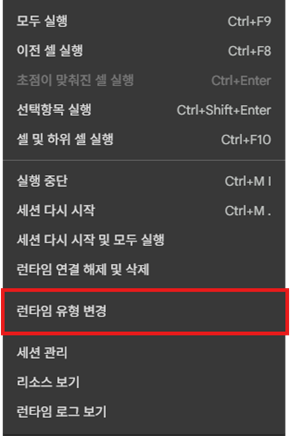

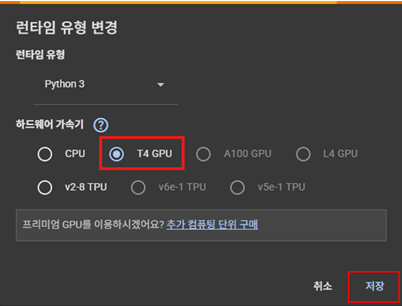

- 필요한 라이브러리 설치 및 호출

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

- GPU 설정

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


- 시드 고정

    - 동일한 실습 환경에서도 모델의 학습 결과가 일관되도록 랜덤성을 최소화
    - 이를 통해 코드 실행 시 매번 동일한 결과를 재현

In [3]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

## 1. MNIST 데이터셋 준비
- 데이터셋 불러오기(로드) (이미지→텐서) → 0과 1에 대한 이미지만 선택 → Train/Test 데이터셋 나누기 → Dataloader 설정

In [4]:
# 이미지를 텐서 형태로 바꾸어줄 함수
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 데이터셋 불러오기 (0과 1에 대한 이미지만 선택)
# Pytorch Dataset 형태
train_full = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_indices = (train_full.targets == 0) | (train_full.targets == 1)
train_dataset = Subset(train_full, torch.where(train_indices)[0])

test_full = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_indices = (test_full.targets == 0) | (test_full.targets == 1)
test_dataset = Subset(test_full, torch.where(test_indices)[0])

# DataLoader 설정
g = torch.Generator()
g.manual_seed(42)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, worker_init_fn=seed_worker,generator=g)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, worker_init_fn=seed_worker,generator=g)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.12MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.23MB/s]


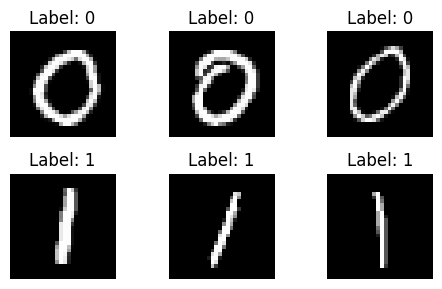

In [5]:
# 불러온 데이터 확인하기
import matplotlib.pyplot as plt

examples = next(iter(train_loader))
images, labels = examples

images = images.cpu()
labels = labels.cpu()

zero_indices = (labels == 0).nonzero(as_tuple=True)[0][:3]
one_indices = (labels == 1).nonzero(as_tuple=True)[0][:3]

selected_indices = torch.cat([zero_indices, one_indices])

fig, axes = plt.subplots(2, 3, figsize=(5, 3))

for idx, ax in enumerate(axes.flat):
    img = images[selected_indices[idx]]
    label = labels[selected_indices[idx]]

    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f"Label: {int(label.item())}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## 2. 모델 구축, 학습, 평가


#### 2.1 모델 구축
  - 총 2개의 fully connected layer로 구성된 모델
  - 각 fully connected layer는 sigmoid를 포함
   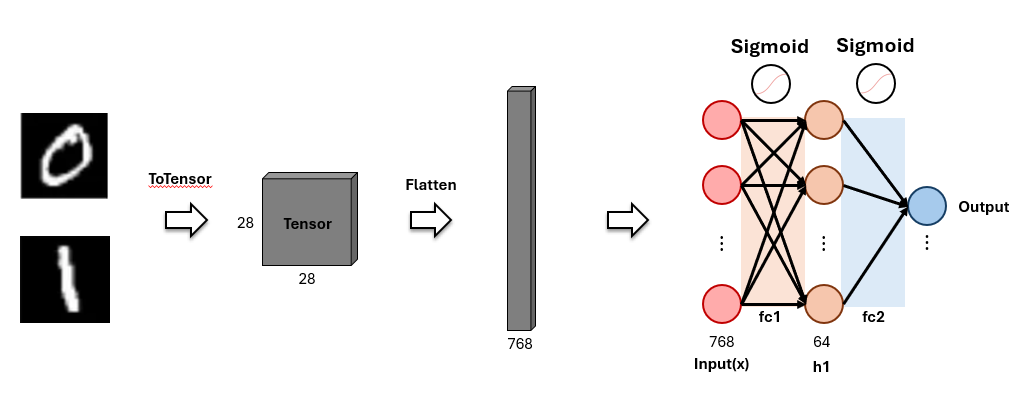

In [6]:
# 모델 정의
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 64),
            nn.Sigmoid(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

# 모델 구축
model = BinaryClassifier().to(device)

### 2.2 모델 학습 준비

- **Loss Function** : 모델의 output이 실제 정답과 얼마나 유사한지를 나타내는 함수
  
  - 두 값이 서로 유사할수록 함수값이 작아지며, 이 함수를 최소화 하는 것이 모델의 최종 학습 목표
  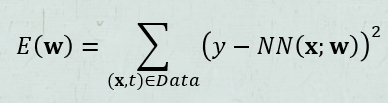

- **Optimizer** : Loss function이 최소화되도록 모델의 Weight를 업데이트 하는 역할

  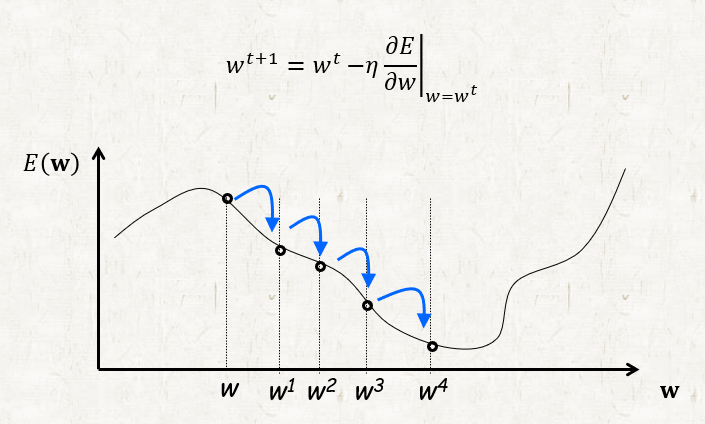

- Learning Rate(η) : 모델이 Weight를 얼마나 업데이트 할 지를 결정하는 역할

In [7]:
criterion = nn.MSELoss() # Loss function
optimizer = optim.SGD(model.parameters(), lr=0.001) # Optimizer, Learning Rate : 0.001

### 2.3 모델 학습 및 평가

- **모델 학습** : Train 데이터셋으로, 모델의 output이 실제 정답과 유사해지도록, 즉 Loss function이 최소화되도록 Optimizer를 통해 학습

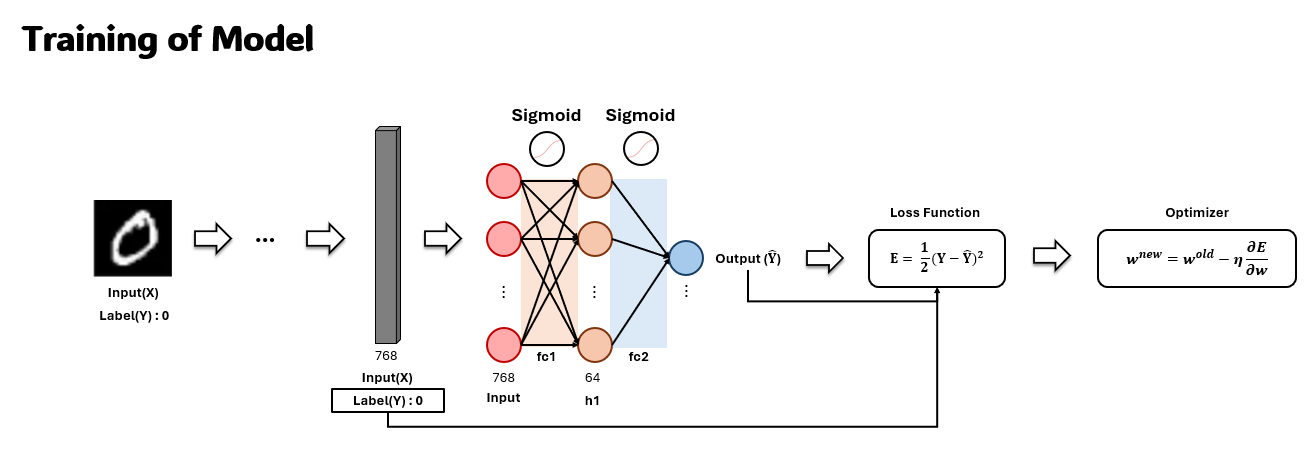

In [11]:
# train 함수
def train(model, loader, criterion, optimizer):
    # model을 학습 상태로 설정
    model.train()
    running_loss = 0.0

    for inputs, labels in loader:
        # Dataloader로 데이터를 불러옴
        # 데이터는 input(X)과 label(Y)로 이루어짐
        inputs = inputs.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        # 모델에 input을 입력하여 결과를 얻음
        outputs = model(inputs)

        # Loss를 계산 (E = ½(Y-Y_hat)^2)
        loss = criterion(outputs, labels)

        optimizer.zero_grad() # Optimizer가 기존에 계산한 결과물들을 초기화하기 위한 과정
        loss.backward() # Loss의 미분 값(Gradient)을 구함
        optimizer.step() # Loss의 미분 값을 활용하여 weight를 업데이트 (Gradient Descent)

        running_loss += loss.item()

    avg_loss = running_loss / len(loader)
    return avg_loss

- **모델 평가** : 학습한 모델이 Test 데이터셋의 라벨(여기서는 0 or 1)을 얼마나 잘 예측하는지 평가

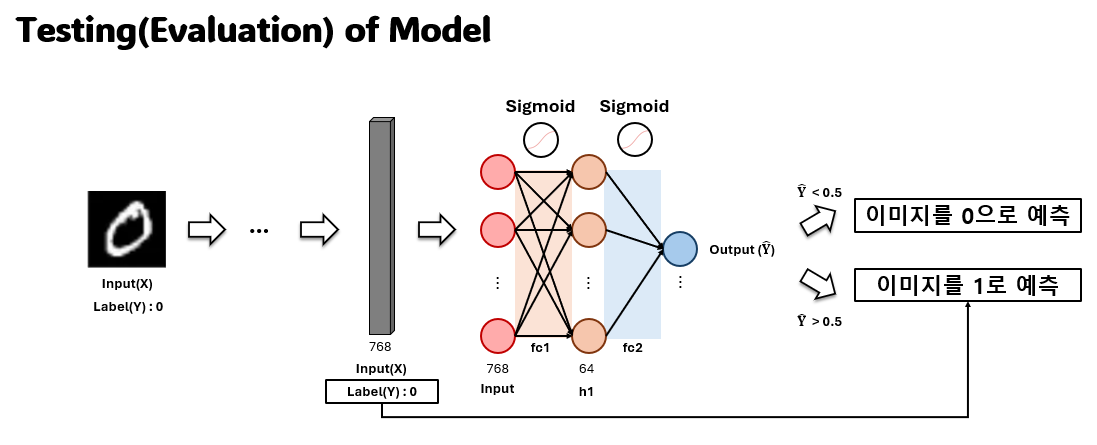

- 성능 평가 지표
  - Test Loss : Test 데이터셋에 대한 모델의 평균 Loss 값
  - Test Accuracy : 모델이 Test 데이터셋에 있는 전체 데이터 중에서 라벨을 올바르게 맞춘 비율
    - (모델이 라벨을 맞춘 데이터 수 / 전체 데이터 수)

In [12]:
# evaluate 함수
def evaluate(model, loader, criterion):
    # model을 평가 상태로 설정
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            # Dataloader로 데이터 (input, label)를 불러옴
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            # 모델에 input을 입력한 결과를 얻음
            outputs = model(inputs)

            # 현재 데이터의 Loss 계산
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # 모델의 output이 0.5 이상이라면 1, 0.5 이하라면 0으로 예측했다고 판단
            preds = (outputs > 0.5).int()

            # 데이터의 label과 모델의 예측한 결과를 비교하여 모델이 정확히 예측한 데이터 개수를 측정
            labels_int = labels.int()
            correct += (preds == labels_int).sum().item()
            total += labels.size(0)

    # Test Loss (전체 데이터의 평균 Loss) 계산
    avg_loss = running_loss / len(loader)
    # Test Accuracy (모델이 예측한 데이터 개수 / 전체 데이터 수) 계산
    accuracy = correct / total

    return avg_loss, accuracy

- 모델을 한 번 학습할 때마다, 모델의 성능을 평가

In [13]:
# 시드 고정
set_seed(20)

# 학습 및 평가
num_epochs = 10

for epoch in range(num_epochs):
    # 모델 학습
    train_loss = train(model, train_loader, criterion, optimizer)
    # 모델 평가
    test_loss, test_acc = evaluate(model, test_loader, criterion)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")

Epoch [1/10] - Train Loss: 0.1368 | Test Loss: 0.1300 | Test Acc: 98.82%
Epoch [2/10] - Train Loss: 0.1269 | Test Loss: 0.1203 | Test Acc: 99.10%
Epoch [3/10] - Train Loss: 0.1175 | Test Loss: 0.1112 | Test Acc: 99.15%
Epoch [4/10] - Train Loss: 0.1088 | Test Loss: 0.1028 | Test Acc: 99.20%
Epoch [5/10] - Train Loss: 0.1008 | Test Loss: 0.0950 | Test Acc: 99.24%
Epoch [6/10] - Train Loss: 0.0934 | Test Loss: 0.0879 | Test Acc: 99.34%
Epoch [7/10] - Train Loss: 0.0866 | Test Loss: 0.0814 | Test Acc: 99.39%
Epoch [8/10] - Train Loss: 0.0804 | Test Loss: 0.0755 | Test Acc: 99.43%
Epoch [9/10] - Train Loss: 0.0748 | Test Loss: 0.0701 | Test Acc: 99.43%
Epoch [10/10] - Train Loss: 0.0698 | Test Loss: 0.0653 | Test Acc: 99.43%


- 모델 예측 결과 시각화

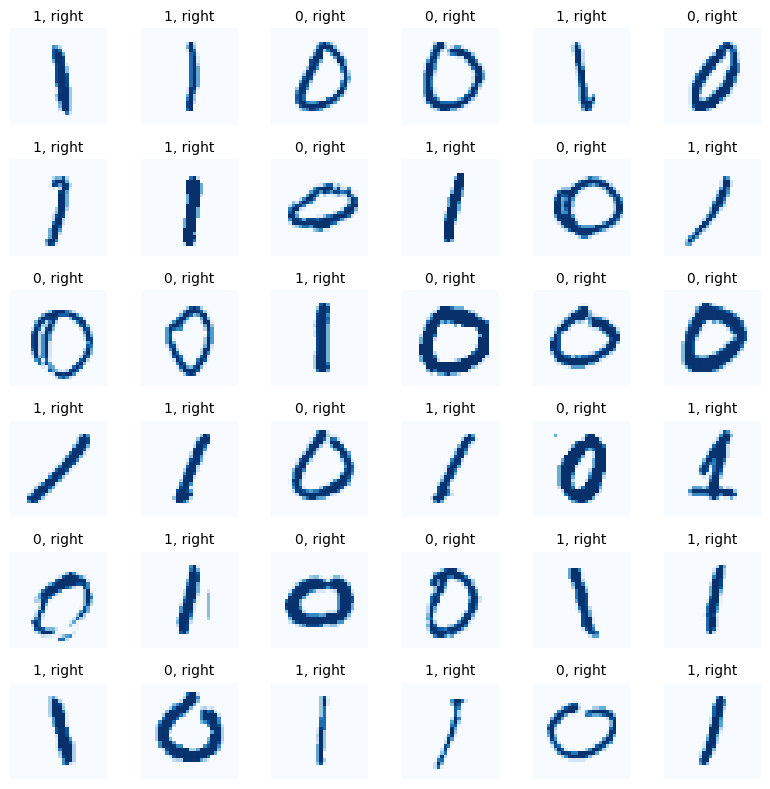

In [14]:
import matplotlib.pyplot as plt
import numpy as np

labels_map = {
    0: "0",
    1: "1"
}

columns = 6
rows = 6
fig = plt.figure(figsize=(8,8))

model.eval()
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_dataset))
    input_img = test_dataset[data_idx][0].unsqueeze(dim=0).to(device)
    true_label = test_dataset[data_idx][1]

    with torch.no_grad():
        output = model(input_img)
        pred_prob = output.squeeze().item()
        pred_label = 1 if pred_prob > 0.5 else 0

    fig.add_subplot(rows, columns, i)

    if pred_label == true_label:
        plt.title(f"{labels_map[pred_label]}, right", fontsize=10)
        cmap = 'Blues'
    else:
        plt.title(f"N {labels_map[pred_label]} / T {labels_map[true_label]}", fontsize=10)
        cmap = 'Reds'

    plot_img = test_dataset[data_idx][0][0,:,:].cpu()
    plt.imshow(plot_img, cmap=cmap)
    plt.axis('off')

plt.tight_layout()
plt.show()

## 3. Learning Curve & Learning Rate

#### 3.1 Learning Curve
  - 모델을 학습함에 따라 Train Loss가 어떻게 변하는지를 나타낸 그래프

  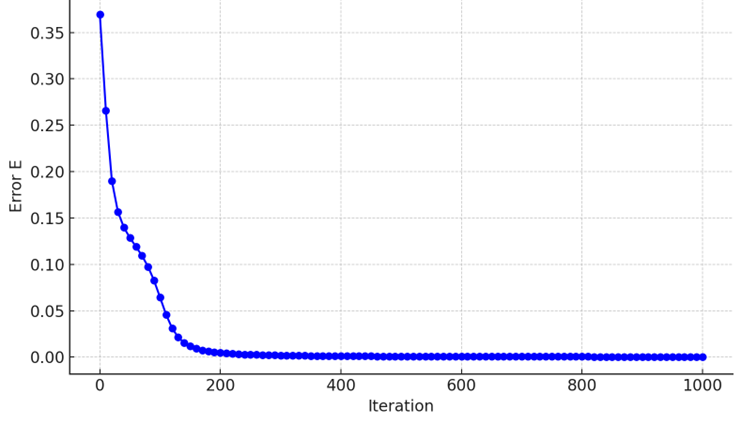

In [15]:
# 모델의 학습 횟수
num_epochs = 10

# 모델 정의
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 64),
            nn.Sigmoid(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

# 모델 구축
model = BinaryClassifier().to(device)

# Loss function & Optimizer 정의
criterion = nn.MSELoss() # Loss function
optimizer = optim.SGD(model.parameters(), lr=0.001) # Optimizer, Learning Rate : 0.001

# 시드 고정
set_seed(20)

# 학습 및 평가
train_losses = [] # train_loss를 저장할 리스트
for epoch in range(num_epochs):
    # 모델 학습
    train_loss = train(model, train_loader, criterion, optimizer)
    train_losses.append(train_loss) # 학습 마다 train_loss를 축적
    # 모델 평가
    test_loss, test_acc = evaluate(model, test_loader, criterion)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")

Epoch [1/10] - Train Loss: 0.2435 | Test Loss: 0.2375 | Test Acc: 53.71%
Epoch [2/10] - Train Loss: 0.2337 | Test Loss: 0.2276 | Test Acc: 57.68%
Epoch [3/10] - Train Loss: 0.2240 | Test Loss: 0.2177 | Test Acc: 69.88%
Epoch [4/10] - Train Loss: 0.2141 | Test Loss: 0.2076 | Test Acc: 81.99%
Epoch [5/10] - Train Loss: 0.2041 | Test Loss: 0.1974 | Test Acc: 89.13%
Epoch [6/10] - Train Loss: 0.1939 | Test Loss: 0.1869 | Test Acc: 94.09%
Epoch [7/10] - Train Loss: 0.1835 | Test Loss: 0.1763 | Test Acc: 96.22%
Epoch [8/10] - Train Loss: 0.1730 | Test Loss: 0.1656 | Test Acc: 96.97%
Epoch [9/10] - Train Loss: 0.1624 | Test Loss: 0.1550 | Test Acc: 98.16%
Epoch [10/10] - Train Loss: 0.1520 | Test Loss: 0.1446 | Test Acc: 98.53%


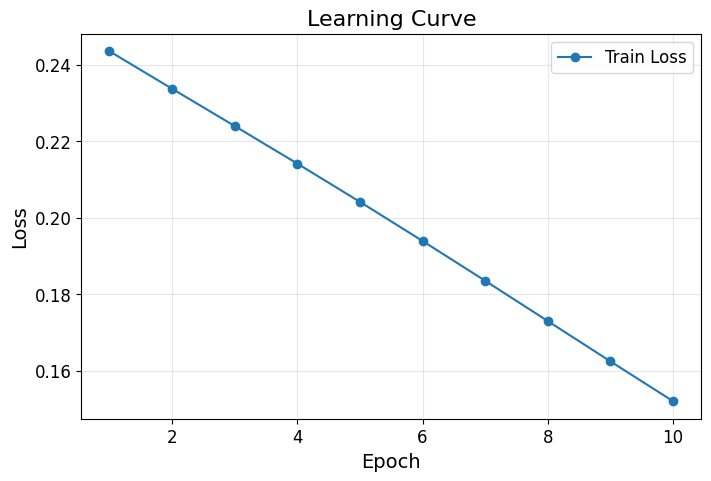

In [16]:
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, marker='o', label='Train Loss')
plt.title('Learning Curve', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.show()

- 200번 학습했을 때의 Training Curve

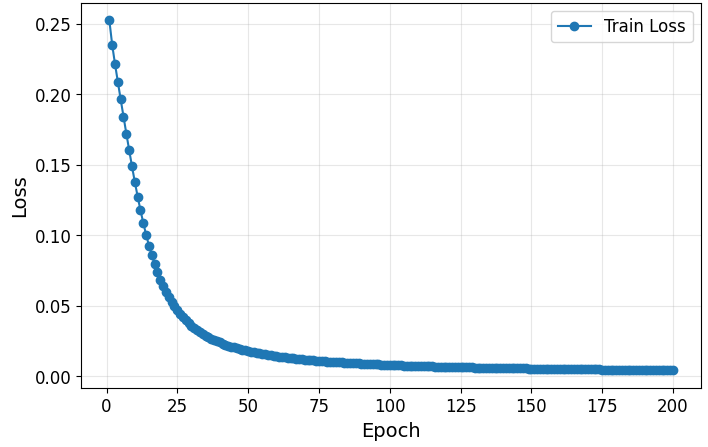

####3.2 Learning Rate

- Learning Rate(η) : 모델이 Weight를 **얼마나 업데이트** 할 지를 결정하는 역할
  - 매우 큰 Learning Rate : Weight를 너무 많이 업데이트하여 성능이 좋지 않음
  - 너무 적은 Learning Rate : Weight를 너무 적게 업데이트하여 성능이 좋지 않음
  - **적절한 Learning Rate** : Weight를 적절히 업데이트하여 좋은 성능을 얻을 수 있음
  
   ![image.png](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbeNGrz%2FbtqQzRMQAQx%2FE5HgPj8oe4AugHgHxS7RlK%2Fimg.png)

- Learning Rate에 따른 성능 시각화

In [21]:
# Learning Rate
learning_rates = [0.00001, 0.001, 10]

# 모델 정의
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 64),
            nn.Sigmoid(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.fc(x)

test_accuracies_dict = {}

for learning_rate in learning_rates:
  print(f"=====================Learning Rate : {learning_rate}=====================")
  # 모델 구축
  model = BinaryClassifier().to(device)

  # Loss function & Optimizer 정의
  criterion = nn.MSELoss() # Loss function
  optimizer = optim.SGD(model.parameters(), lr=learning_rate) # Optimizer

  test_accuracies = []

  # 시드 고정
  set_seed(20)

  # 모델의 학습 횟수
  num_epochs = 5

  # 학습 및 평가
  train_losses = []
  for epoch in range(num_epochs):

      # 모델 학습
      train_loss = train(model, train_loader, criterion, optimizer)
      # 모델 평가
      test_loss, test_acc = evaluate(model, test_loader, criterion)
      test_accuracies.append(test_acc * 100)
      print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")

  test_accuracies_dict[learning_rate] = test_accuracies

=====================Learning Rate : 1e-05=====================
Epoch [1/5] - Train Loss: 0.2484 | Test Loss: 0.2476 | Test Acc: 53.66%
Epoch [2/5] - Train Loss: 0.2483 | Test Loss: 0.2475 | Test Acc: 53.66%
Epoch [3/5] - Train Loss: 0.2482 | Test Loss: 0.2474 | Test Acc: 53.66%
Epoch [4/5] - Train Loss: 0.2481 | Test Loss: 0.2473 | Test Acc: 53.66%
Epoch [5/5] - Train Loss: 0.2480 | Test Loss: 0.2472 | Test Acc: 53.66%
=====================Learning Rate : 0.001=====================
Epoch [1/5] - Train Loss: 0.2435 | Test Loss: 0.2375 | Test Acc: 53.71%
Epoch [2/5] - Train Loss: 0.2337 | Test Loss: 0.2276 | Test Acc: 57.21%
Epoch [3/5] - Train Loss: 0.2240 | Test Loss: 0.2177 | Test Acc: 69.55%
Epoch [4/5] - Train Loss: 0.2141 | Test Loss: 0.2076 | Test Acc: 82.55%
Epoch [5/5] - Train Loss: 0.2041 | Test Loss: 0.1974 | Test Acc: 89.31%
=====================Learning Rate : 10=====================
Epoch [1/5] - Train Loss: 0.5300 | Test Loss: 0.5403 | Test Acc: 46.34%
Epoch [2/5] - Train

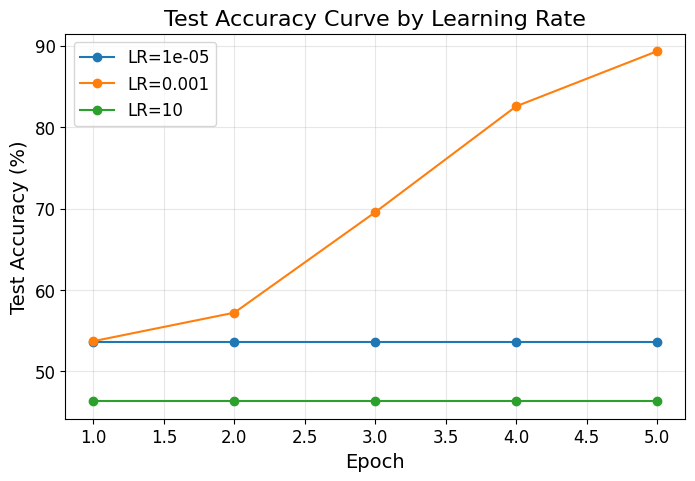

In [23]:
plt.figure(figsize=(8,5))
for lr, accs in test_accuracies_dict.items():
    plt.plot(range(1, num_epochs+1), accs, marker='o', label=f"LR={lr}")

plt.title('Test Accuracy Curve by Learning Rate', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Test Accuracy (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)
plt.show()